/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


📊 Resultados en el Test (AQI | CO exógena)
MAE :  0.102
RMSE:  0.126
R²  :  0.995
MAPE:  1.43%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


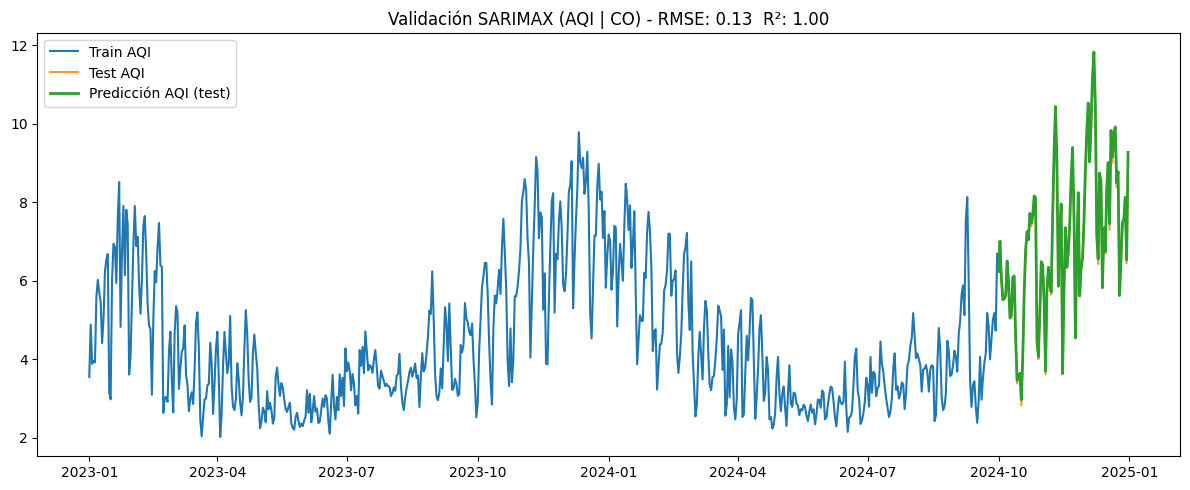

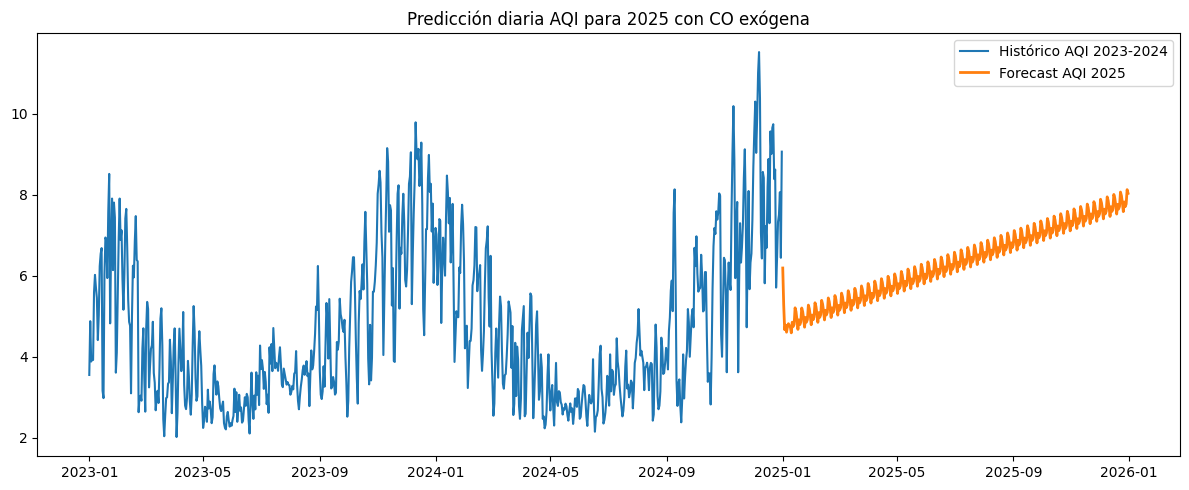

2025-01-01    6.188766
2025-01-02    5.278726
2025-01-03    4.668564
2025-01-04    4.779426
2025-01-05    4.606000
2025-01-06    4.743178
2025-01-07    4.815876
2025-01-08    4.765070
2025-01-09    4.734580
2025-01-10    4.589458
Freq: D, Name: AQI_2025, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# 1) Cargar, unir y limpiar
# =========================
df_2023 = pd.read_csv("Dataset-2023.csv")
df_2024 = pd.read_csv("Dataset-2024.csv")
df = pd.concat([df_2023, df_2024], ignore_index=True)

df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y", errors="coerce")

# Promedio por día (varios sitios -> una fila por fecha)
daily = (df.groupby("Date", as_index=True)[["Daily AQI Value", "Daily Max 8-hour CO Concentration"]]
           .mean()
           .sort_index())

# Índice diario continuo + interpolación temporal
daily = daily.asfreq("D")
daily = daily.interpolate("time")
daily.index.name = "Date"

# Series finales
y_aqi = daily["Daily AQI Value"].astype(float)                      # objetivo
x_co  = daily["Daily Max 8-hour CO Concentration"].astype(float)    # exógena

# =========================
# 2) Split train / test
# =========================
train_end = "2024-09-30"
y_train = y_aqi.loc[:train_end]
y_test  = y_aqi.loc["2024-10-01":]

x_train = x_co.loc[:train_end]
x_test  = x_co.loc["2024-10-01":]

# =========================
# 3) MODELO 1: CO univariante (para generar exógena futura)
# =========================
co_model = SARIMAX(x_train,
                   order=(2,1,2),
                   seasonal_order=(1,1,1,7),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit(disp=False)

# Predicción CO en el tramo de test (para evaluar consistencia)
start = len(x_train)
end   = len(x_train) + len(x_test) - 1
co_pred_test = co_model.predict(start=start, end=end)

# =========================
# 4) MODELO 2: AQI con exógena CO (SARIMAX)
# =========================
aqi_model = SARIMAX(y_train, exog=x_train,
                    order=(2,1,2),
                    seasonal_order=(1,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)

# Predicción AQI en test usando la CO REAL del test
aqi_pred_test = aqi_model.predict(start=len(y_train),
                                  end=len(y_train)+len(y_test)-1,
                                  exog=x_test)

# =========================
# 5) Métricas en el test
# =========================
y_true = np.asarray(y_test)
y_pred = np.asarray(aqi_pred_test)

mae = mean_absolute_error(y_true, y_pred)
try:
    rmse = mean_squared_error(y_true, y_pred, squared=False)
except TypeError:  # por compatibilidad con sklearn viejo
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("📊 Resultados en el Test (AQI | CO exógena)")
print(f"MAE :  {mae:.3f}")
print(f"RMSE:  {rmse:.3f}")
print(f"R²  :  {r2:.3f}")
print(f"MAPE:  {mape:.2f}%")

# =========================
# 6) Forecast 2025
# =========================
# 6.1) Forecast CO para 2025 (exógena futura)
steps_2025 = 365  # 2025 no es bisiesto
co_future_vals = co_model.get_forecast(steps=steps_2025).predicted_mean
co_future_idx  = pd.date_range(x_co.index.max() + pd.Timedelta(days=1),
                               periods=steps_2025, freq="D")
co_future = pd.Series(co_future_vals.values, index=co_future_idx, name="CO_2025")

# 6.2) Re-ajustar AQI con TODO 2023-2024 (mejor para pronóstico) y predecir 2025
aqi_full = SARIMAX(y_aqi, exog=x_co,
                   order=(2,1,2),
                   seasonal_order=(1,1,1,7),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit(disp=False)

aqi_fc_2025_vals = aqi_full.get_forecast(steps=steps_2025, exog=co_future.values).predicted_mean
aqi_fc_2025 = pd.Series(aqi_fc_2025_vals.values, index=co_future_idx, name="AQI_2025")

# =========================
# 7) Gráficos
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Train AQI")
plt.plot(y_test.index, y_test, label="Test AQI", alpha=0.8)
plt.plot(y_test.index, aqi_pred_test, label="Predicción AQI (test)", linewidth=2)
plt.title(f"Validación SARIMAX (AQI | CO) - RMSE: {rmse:.2f}  R²: {r2:.2f}")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_aqi.index, y_aqi, label="Histórico AQI 2023-2024")
plt.plot(aqi_fc_2025.index, aqi_fc_2025, label="Forecast AQI 2025", linewidth=2)
plt.title("Predicción diaria AQI para 2025 con CO exógena")
plt.legend(); plt.tight_layout(); plt.show()

# Vista rápida del forecast
print(aqi_fc_2025.head(10))
